In [194]:
import geopandas as gpd
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
import matplotlib.pyplot as plt
import os 
import adjustText as aT
os.chdir("/Users/hango/Desktop/UCDavis(2019-)/winter2020/STA220/final_project/final_project-master/data")
file_path = '../states_province/ne_110m_admin_1_states_provinces.shx'
file_path2 = '../states2/s_11au16.shx'




In [110]:
from bokeh.io import output_notebook, show, output_file, curdoc
from bokeh.plotting import figure, save
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool,ColumnDataSource
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column
from bokeh.models.glyphs import Text

## load data

In [195]:
data_all = pd.read_csv("USnew_overall_rank.csv")
data_stat = pd.read_csv("USnew_stat_rank.csv")
map_us = gpd.read_file(file_path)
map_us2 = gpd.read_file(file_path2)
%run "../code/clean.py"


## Merge Data

In [196]:
data_stat["postal"] = data_stat["district"].str.split(',', expand = True).iloc[:,1].str.strip()
df = pd.merge(df, data_stat, left_on = "institution", right_on = "name")
summary_gradcafe = df[["postal", "admission_status"]].groupby("postal").apply(lambda df: np.sum(df["admission_status"] == "Accepted") / df["admission_status"].count()).reset_index()
summary_gradcafe["admission_rate"] = df[["postal", "admission_status"]].groupby("postal").count().reset_index().iloc[:,1]
summary_gradcafe["stat_score"] = df[["USnew_stat_score", "postal"]].groupby("postal").mean().reset_index().iloc[:,1]
summary_gradcafe["overall_score"] = df[["USnew_overall_score", "postal"]].groupby("postal").mean().reset_index().iloc[:,1]
summary_gradcafe["sum_stat_score"] = df[["USnew_stat_score", "postal"]].groupby("postal").sum().reset_index().iloc[:,1]
summary_gradcafe = summary_gradcafe.rename(columns = {0 : "admission_rate", "admission_rate": "num_applicants"})

map_us = map_us.merge(summary_gradcafe, on = "postal", how = 'left')
map_us.loc[map_us["num_applicants"].isna(), "num_applicants"]=0
map_us_point = map_us.copy()
map_us_point["rep"] = map_us["geometry"].centroid
map_us_point.set_geometry("rep", inplace = True)

In [202]:

#Read data to json
merged_json = json.loads(map_us[~map_us['name'].isin(['Alaska', 'Hawaii'])].to_json())

#Convert to str like object
json_data = json.dumps(merged_json)

geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['OrRd'][5]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 5, nan_color = '#d9d9d9')

#Define custom tick labels for color bar.
#tick_labels = {'0': '0%', '1': '5%', '2':'10%', '3':'15%', '4':'20%', '5':'25%'}

#Add hover tool
hover = HoverTool(tooltips = [ ('States', '@name'),('admission_rate', "@admission_rate"),('Numbers of applicants','@num_applicants'), ('Sum of stat score','@sum_stat_score'),('Mean stat score', '@stat_score'),('Overall score', '@overall_score')])


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Statistics Score for states in USA', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.title.text = 'Statistics Score for States'
p.title.align = 'center'
p.title.text_font_size = '25px'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'stat_score', 'transform' : color_mapper},
          line_color = 'yellow', line_width = 0.25, fill_alpha = 1)

p.add_layout(color_bar, 'below')

#add text
map_us_points = map_us_point[map_us_point["stat_score"] > 3.5]
glyph = Text(x="x", y="y", text="text", text_color="#96deb3", text_font = '15px')
source = ColumnDataSource(dict(x = map_us_points.geometry.x, y = map_us_points.geometry.y, text = map_us_points["postal"]))
p.add_glyph(source, glyph)
#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)



Loading BokehJS ...

'/Users/hango/Desktop/UCDavis(2019-)/winter2020/STA220/final_project/final_project-master/figure.html'

## Merge gradcafe data with stat_rank data and USmap data

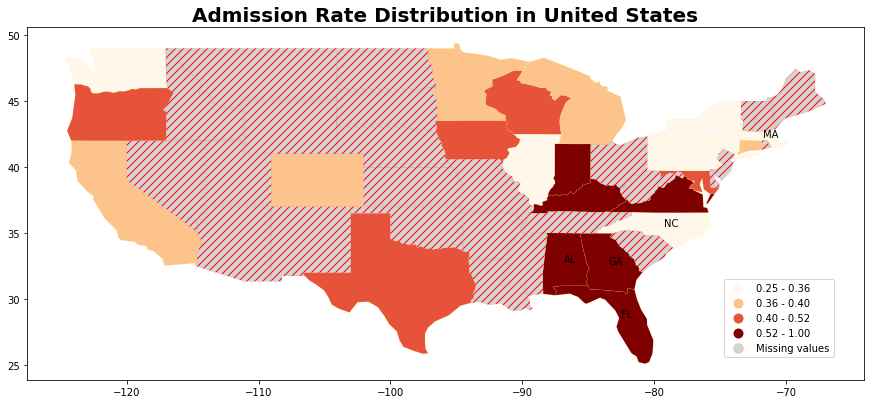

In [205]:
import mapclassify as mp
feature = "admission_rate"
fig, ax = plt.subplots(1, figsize=(15, 8))
plt.title("Admission Rate Distribution in United States", size = 20,fontweight="bold")
divider = make_axes_locatable(ax)
#add text
map_us_points = map_us_point[(map_us_point[feature]>0.6) | (map_us_point[feature]<0.3)]
texts= []
for x, y, label in zip(map_us_points.geometry.x, map_us_points.geometry.y, map_us_points["postal"]):
    texts.append(plt.text(x, y, label, fontsize = 10))
#cax = divider.append_axes("bottom", size = "5%", pad = 0.)
map_us[~map_us['name'].isin(['Alaska', 'Hawaii'])].plot(
            column = feature, 
            scheme = "QUANTILES",
            k = 4,
            cmap = 'OrRd', 
            edgecolor = "yellow", 
            linewidth = 0.1,
            legend = True,
            #legend_kwds = {'label': "Admission_rate", "orientation": "horizontal"},
            ax = ax,
            missing_kwds={
                                     "color": "lightgrey",
                                     "edgecolor": "red",
                                     "hatch": "///",
                                     "label": "Missing values",
                                             },
            #cax = cax
           )
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.97, 0.3))




In [208]:
feature = "num_applicants"

#Read data to json
merged_json = json.loads(map_us[~map_us['name'].isin(['Alaska', 'Hawaii'])].to_json())

#Convert to str like object
json_data = json.dumps(merged_json)

geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['OrRd'][8]

#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1400, nan_color = '#d9d9d9')

#Define custom tick labels for color bar.
#tick_labels = {'0': '0%', '0.2': '5%', '':'10%', '3':'15%', '4':'20%', '5':'25%'}

#Add hover tool
hover = HoverTool(tooltips = [ ('States', '@name'),('admission_rate', "@admission_rate"), ('Numbers of applicants','@num_applicants'),('Average stat score', '@stat_score'),('Overall score', '@overall_score')])


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Numbers of Applicants for States', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.title.text = 'Numbers of Applicants for States'
p.title.align = 'center'
p.title.text_font_size = '25px'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :feature, 'transform' : color_mapper},
          line_color = 'yellow', line_width = 0.25, fill_alpha = 1)

p.add_layout(color_bar, 'below')

#add text
map_us_points = map_us_point[map_us_point[feature] > 300]
glyph = Text(x="x", y="y", text="text", text_color="orangered", text_font = '15px')
source = ColumnDataSource(dict(x = map_us_points.geometry.x, y = map_us_points.geometry.y, text = map_us_points["postal"]))
p.add_glyph(source, glyph)
#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

outfp = r"../figure2.html"
save(obj = p, filename = outfp)

Loading BokehJS ...

'/Users/hango/Desktop/UCDavis(2019-)/winter2020/STA220/final_project/final_project-master/figure2.html'